In [1]:
import os, gc, sys, h5py, json, math, time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
from PIL import Image
from os import listdir
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD,Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import ResNet50, preprocess_input

c:\users\zaid\anaconda2\envs\tensorflow3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Print size of any object
def memo_obj(obj):
    print(sys.getsizeof(obj)/ 1024**2," MB")

def change_datatype(df):
    int_cols = list(df.select_dtypes(include=['int']).columns)
    for col in int_cols:
        if ((np.max(df[col]) <= 127) and(np.min(df[col] >= -128))):
            df[col] = df[col].astype(np.int8)
        elif ((np.max(df[col]) <= 32767) and(np.min(df[col] >= -32768))):
            df[col] = df[col].astype(np.int16)
        elif ((np.max(df[col]) <= 2147483647) and(np.min(df[col] >= -2147483648))):
            df[col] = df[col].astype(np.int32)
        else:
            df[col] = df[col].astype(np.int64)
    return df

def show_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img, interpolation='nearest')
    plt.show()

# Get per class acc and mse
def per_class_scores(conf_mat, label_test):
    res = defaultdict(list)
    Ns = []
    for i in range(conf_mat.shape[0]):
        n = np.sum(conf_mat[i, :])
        acc = conf_mat[i,i] / n
        mse = np.sum([conf_mat[i,j] * ((j-i) ** 2) for j in range(conf_mat.shape[1])]) / n
        Ns.append(n)
        res['MSEs'].append(mse)
        res['Accs'].append(acc)
        print("Label", i, "acc:", acc, " mse:", mse)
    overall_acc = np.sum([conf_mat[i,i] for i in range(conf_mat.shape[0])]) / len(label_test)
    overall_mse = np.dot(res['MSEs'], Ns) / np.sum(Ns)
    print("Overall acc. is", overall_acc)
    print("Overall MSE is", overall_mse)
    res['MSEs'].append(overall_mse)
    res['Accs'].append(overall_acc)
    res['label'] = ['label_' + str(i) for i in range(6)] + ['overall']
    return pd.DataFrame(res)

def model_eval(model_name, pred_values, test_time_augment = False):
    new_name = model_name + '_test_aug' if test_time_augment else model_name
    # plot conf_matrix
    conf_mat = confusion_matrix(label_test, pred_values)
    sns.heatmap(conf_mat, annot = True, cmap = 'Blues')
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.savefig(plot_output_path + "conf_mat\\" + new_name + '_confmat', fmt = 'png', dpi = 300)
    
    # Save model evaluation, per class acc and mse
    res = per_class_scores(conf_mat, label_test)
    res.to_csv(model_eval_path + new_name + '.csv', index = None)
    
def test_time_augmentation(model, mode = 2):
    ''' mode = 1: majority vote after argmax,
        mode = 2: sum up all the probabilitys and then argmax '''
    assert(mode == 1 or mode == 2)
    pred_o = model.predict(df_test[predictors])
    pred_h = model.predict(df_test_h[predictors])
    pred_v = model.predict(df_test_v[predictors])
    if mode == 1:
        pred_o = np.argmax(pred_o, axis=1)
        pred_h = np.argmax(pred_h, axis=1)
        pred_v = np.argmax(pred_v, axis=1)
        final = []
        for i in range(pred_o.shape[0]):
            final.append(np.argmax(np.bincount([pred_o[i],pred_h[i],pred_v[i]])))
    else:
        pred_final = np.sum([pred_o, pred_h, pred_v], axis = 0)
        final = np.argmax(pred_final, axis = 1)
    return final

def lgb_modelfit_nocv(params, dtrain, dvalid, predictors, target='target', \
                      objective='multiclass', metrics='multi_logloss', # multi_error\
                      feval=None, early_stopping_rounds=20, num_boost_round=3000, \
                      verbose_eval=250, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        'num_leaves': 30,  # we should let it be smaller than 2^(max_depth)
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0,  # L1 regularization term on weights
        'reg_lambda': 0,  # L2 regularization term on weights
        'nthread': 8,
        'verbose': 0
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)
    
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features)

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=250, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid']['multi_logloss'][n_estimators-1])

    return bst1, evals_results

In [3]:
base_path = "..\\..\\..\\train_data"
file_path = os.path.join(base_path,"file_labels")
img_path = os.path.join(base_path,"bin-images")
lgb_path = os.path.join(base_path, "lgb_data")
model_output_path = "..\\saved_models\\"
model_eval_path = "..\\model_evaluation\\"
plot_output_path = "..\\visualization\\"

BATCH_SIZE = 32
model_name = "resnet(caffe)_adam_"+str(BATCH_SIZE) + "_random_augment"
dtypes = {'file_name':str, 'label':np.int8, 'sharpness':np.float}

In [4]:
# loading in train data
for i in range(4):
    print("Loading in batch:", i)
    if i == 0:
        df_train = pd.read_csv(lgb_path +'\\' + model_name + '_train_orig_'+str(i)+'.csv', dtype = dtypes)
    else:
        df_train = pd.concat([df_train, pd.read_csv(lgb_path +'\\' + model_name + '_train_orig_'+str(i)+'.csv', dtype = dtypes)])
print(df_train.shape)

Loading in batch: 0
Loading in batch: 1
Loading in batch: 2
Loading in batch: 3
(289536, 2051)


In [5]:
# loading in val and test data
df_val = pd.read_csv(lgb_path +'\\' + model_name + '_val.csv', dtype = dtypes)
df_test = pd.read_csv(lgb_path +'\\' + model_name + '_test.csv', dtype = dtypes)
print(df_val.shape)
print(df_test.shape)

df_test_h = pd.read_csv(lgb_path +'\\' + model_name + '_test_hflip.csv', dtype = dtypes)
df_test_v = pd.read_csv(lgb_path +'\\' + model_name + '_test_vflip.csv', dtype = dtypes)
print(df_test_h.shape)
print(df_test_v.shape)

(36192, 2051)
(36192, 2051)
(36192, 2051)
(36192, 2051)


In [6]:
sums = [np.sum(df_train[i]) for i in df_train.columns[:2048]]
sums = pd.Series(sums)
predictors = ['res_clf_' + str(i) for i in sums[sums > 0].index]
predictors += ['sharpness']
target = 'label'

In [7]:
res = pd.read_csv('random_search_w_sharpness.csv').sort_values('loss', ascending = True).drop('Unnamed: 0', 1)
res = res[['test_acc'] + [c for c in res.columns if c != 'test_acc']]
res.index = range(len(res))
res.head(5)

,test_acc,colsample_bytree,label_0_acc,label_1_acc,label_2_acc,label_3_acc,label_4_acc,label_5_acc,lambda_l1,lambda_l2,...,loss,max_bin,max_depth,min_child_samples,min_child_weight,n_estimators,num_class,num_leaves,subsample,subsample_freq
0,0.539429,0.3,0.962129,0.809423,0.643681,0.504505,0.384226,0.414809,0.0010,0.010,...,1.049676,450,6,60,0,503,6,21,0.7,3
1,0.539954,0.3,0.966223,0.805889,0.647394,0.503076,0.388018,0.412471,0.0010,0.001,...,1.049734,250,5,60,0,565,6,15,0.7,2
2,0.539290,0.3,0.964176,0.807303,0.646466,0.500220,0.389408,0.411535,0.0100,0.001,...,1.049794,550,5,60,0,842,6,17,0.9,2
3,0.539650,0.3,0.964176,0.807774,0.642488,0.504724,0.389408,0.411535,0.0001,0.010,...,1.049837,250,7,60,0,1063,6,17,0.8,1
4,0.538765,0.3,0.964176,0.804005,0.651638,0.496374,0.391052,0.408106,0.0001,0.010,...,1.049838,250,4,20,0,548,6,15,0.7,1


In [8]:
params = {
        'learning_rate': 0,
        'num_leaves': 0,  # we should let it be smaller than 2^(max_depth)
        'max_depth': 0,  # -1 means no limit
        'min_child_samples': 0,  # Minimum number of data need in a child(min_data_in_leaf)
        'subsample': 0,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 0,  # Minimusm sum of instance weight(hessian) needed in a child(leaf)
        'lambda_l1': 0,
        'lambda_l2':0,
        'max_bin' : 0,
        'num_class': 0
}
for key in params.keys():
    params[key] = res.loc[0, key]
params

{'colsample_bytree': 0.3,
 'lambda_l1': 0.001,
 'lambda_l2': 0.01,
 'learning_rate': 0.03,
 'max_bin': 450,
 'max_depth': 6,
 'min_child_samples': 60,
 'min_child_weight': 0,
 'num_class': 6,
 'num_leaves': 21,
 'subsample': 0.7,
 'subsample_freq': 3}

In [9]:
start_time = time.time()
np.random.seed(47)
bst, evals_results = lgb_modelfit_nocv(params, 
                        df_train, 
                        df_val, 
                        predictors, 
                        target, 
                        objective='multiclass', 
                        metrics='multi_logloss',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=1500)
print("Time taken: ", (time.time() - start_time) / 60, " min")

preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[250]	train's multi_logloss: 0.953834	valid's multi_logloss: 1.05415
[500]	train's multi_logloss: 0.930319	valid's multi_logloss: 1.04973
Early stopping, best iteration is:
[503]	train's multi_logloss: 0.93016	valid's multi_logloss: 1.04968

Model Report
n_estimators :  503
multi_logloss: 1.049676293260375
Time taken:  1.3653007944424946  min


Plot metrics during training...


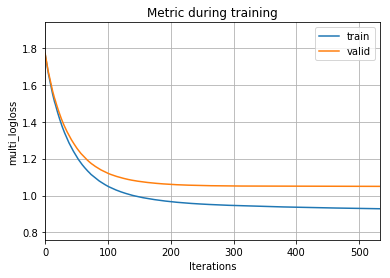

Plot feature importances...


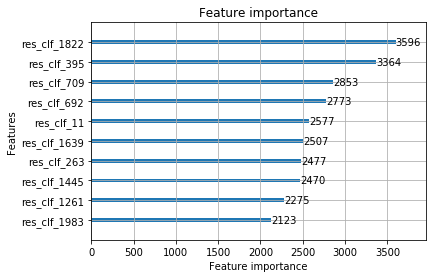

In [10]:
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_results, metric='multi_logloss')
plt.savefig(plot_output_path + 'model_training\\lgb_training', fmt = 'png', dpi = 300)
plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=10)
plt.show()

['res_clf_1822', 'res_clf_395', 'res_clf_709', 'res_clf_692', 'res_clf_11']


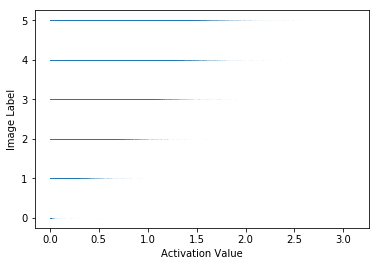

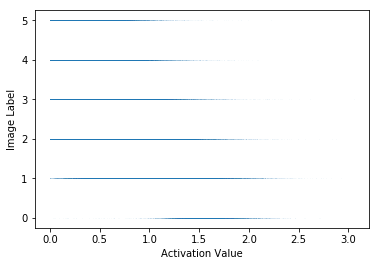

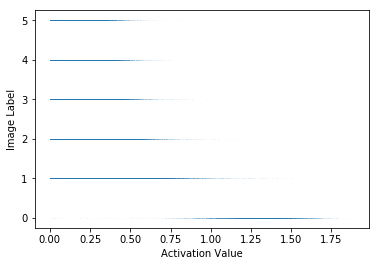

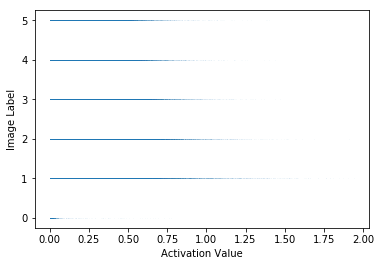

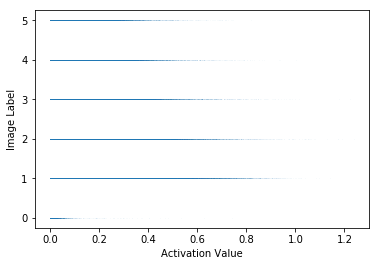

In [11]:
ordered_important_layers = [predictors[i] for i in list(bst.feature_importance().argsort()[::-1][:100])]
print(ordered_important_layers[:5])

for col in ordered_important_layers[:5]:
    plt.figure()
    plt.scatter(df_train[col], df_train['label'], s = 0.01, alpha = 0.1)
    plt.xlabel('Activation Value')
    plt.ylabel('Image Label')
    plt.savefig(plot_output_path + 'activation_values\\activation_value_' + col, fmt = 'png', dpi = 300)

In [12]:
label_test_pred = bst.predict(df_test[predictors])
label_test = df_test.loc[:len(label_test_pred), 'label']
label_test_pred = [np.argmax(label_test_pred[i]) for i in range(label_test_pred.shape[0])]

Label 0 acc: 0.962128966223132  mse: 0.10133060388945753
Label 1 acc: 0.79811542991755  mse: 0.40023557126030623
Label 2 acc: 0.6516377138310568  mse: 0.5794987402201299
Label 3 acc: 0.50439463854098  mse: 0.7452208305866842
Label 4 acc: 0.38814459049544997  mse: 0.9994944388270981
Label 5 acc: 0.4054559625876851  mse: 1.827435697583788
Overall acc. is 0.5389312555260831
Overall MSE is 0.9002541998231653


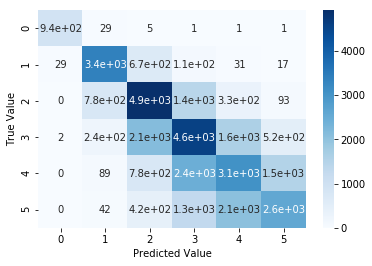

In [13]:
model_eval('resnet_clf_lgb', pred_values = label_test_pred)

Label 0 acc: 0.9682702149437052  mse: 0.09211873080859775
Label 1 acc: 0.8127208480565371  mse: 0.3512367491166078
Label 2 acc: 0.671528974937011  mse: 0.5304336294921098
Label 3 acc: 0.517358822236871  mse: 0.7161063502526918
Label 4 acc: 0.37790697674418605  mse: 1.041582406471183
Label 5 acc: 0.39859703819173814  mse: 1.9337490257209664
Overall acc. is 0.544761273209549
Overall MSE is 0.9047579575596817


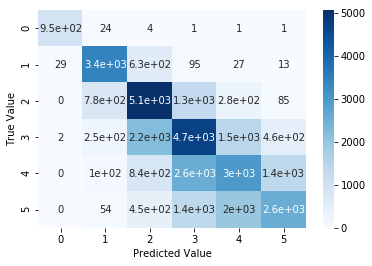

In [14]:
final = test_time_augmentation(bst, mode = 1)
model_eval('resnet_clf_lgb', pred_values = final, test_time_augment = True)

Label 0 acc: 0.970317297850563  mse: 0.09007164790174002
Label 1 acc: 0.8171967020023557  mse: 0.35712603062426385
Label 2 acc: 0.6633072536798833  mse: 0.5564248773372232
Label 3 acc: 0.517139090309822  mse: 0.7183036695231817
Label 4 acc: 0.40230030333670375  mse: 0.9749747219413549
Label 5 acc: 0.4144972720187062  mse: 1.7211223694466096
Overall acc. is 0.5517241379310345
Overall MSE is 0.8591125110521662


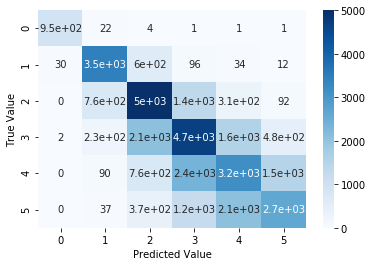

In [15]:
final = test_time_augmentation(bst, mode = 2)
model_eval('resnet_clf_lgb', pred_values = final, test_time_augment = True)